# Explore here

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [4]:
directorio = 'D:\VSC IDE\dogs-vs-cats'
train_dir = os.path.join(directorio, 'train')

In [13]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


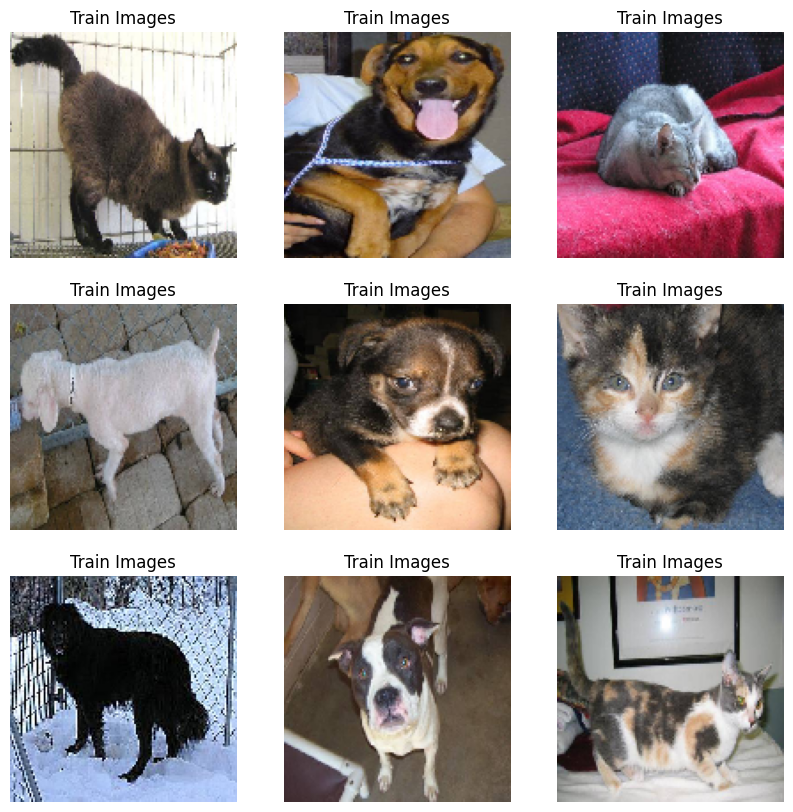

In [19]:
# Visualizamos algunas imágenes

def plot_images(generator, label):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range (9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(label)
        plt.axis('off')
    plt.show()

plot_images(train_generator, 'Train Images')

Para construir la red neuronal hemos escogido MobileNetV2, ya que este modelo viene preentrenado con un conjunto de datos enorme (ImageNet), lo que queire decir que ya ha aprendido a extraer las características principales de las imágenes y no tenemos que definir el modelo desde cero. Al aprovechar este entrenamiento previo solo ajustamos las últimas capas para nuestro problema en concreto, llo que hace más eficiente la velocidad de entrenamiento

In [15]:
# Construimos la red neuronal

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar capas base para evitar que se modifiquen en el entrenamiento inicial
base_model.trainable = False

# Agregar capas personalizadas para la clasificación
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Para clasificación binaria

model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [17]:
# Configurar EarlyStopping para detener entrenamiento si no mejora la validación
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
history = model.fit(
    train_generator,
    epochs=10,  # Ajusta según el tamaño de tu dataset
    validation_data=validation_generator,
    callbacks=[early_stop]
)

Epoch 1/10
625/625 [==============================] - 137s 215ms/step - loss: 0.1064 - accuracy: 0.9577 - val_loss: 0.0934 - val_accuracy: 0.9630
Epoch 2/10
625/625 [==============================] - 135s 216ms/step - loss: 0.0680 - accuracy: 0.9725 - val_loss: 0.0866 - val_accuracy: 0.9642
Epoch 3/10
625/625 [==============================] - 139s 223ms/step - loss: 0.0522 - accuracy: 0.9808 - val_loss: 0.0901 - val_accuracy: 0.9658
Epoch 4/10
625/625 [==============================] - 141s 225ms/step - loss: 0.0387 - accuracy: 0.9863 - val_loss: 0.1015 - val_accuracy: 0.9614
Epoch 5/10
625/625 [==============================] - 146s 233ms/step - loss: 0.0261 - accuracy: 0.9906 - val_loss: 0.1208 - val_accuracy: 0.9646
Epoch 6/10
625/625 [==============================] - 146s 233ms/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.1288 - val_accuracy: 0.9650
Epoch 7/10
625/625 [==============================] - 138s 220ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.1364 -

Una vez entrenado el modelo vamos a testearlo

In [27]:
import random

# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(image_path, target_size=(128, 128)):

    # Carga la imagen y la redimensiona
    img = load_img(image_path, target_size=target_size)

    # Convierte la imagen a un array numpy
    img_array = img_to_array(img)

    # Normaliza los píxeles a rango [0,1]
    img_array = img_array / 255.0
    
    # Expande las dimensiones para simular un batch (tamaño 1)
    return np.expand_dims(img_array, axis=0)

repo_dir = "D:\VSC IDE\Test_classifier"

image_files = [
    os.path.join(repo_dir, f)
    for f in os.listdir(repo_dir)
    if f.lower().endswith('.jpg')
]

print("Número de imágenes encontradas:", len(image_files))



Número de imágenes encontradas: 25000


1/1 [==============================] - 1s 852ms/step
Predicción: Gato para imagen: cat.5310.jpg


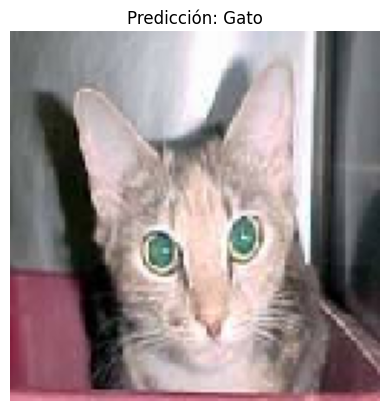

1/1 [==============================] - 0s 36ms/step
Predicción: Perro para imagen: dog.1641.jpg


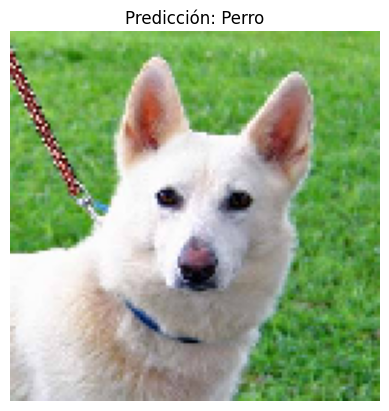

1/1 [==============================] - 0s 43ms/step
Predicción: Perro para imagen: dog.6953.jpg


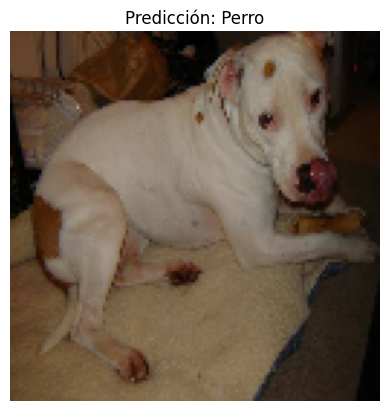

1/1 [==============================] - 0s 32ms/step
Predicción: Perro para imagen: dog.9.jpg


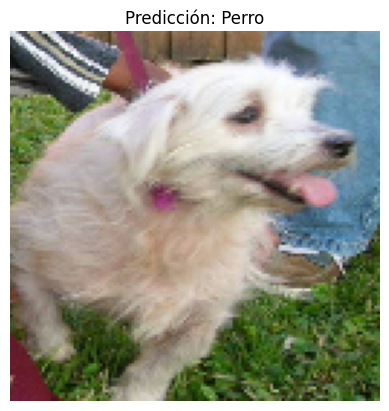

1/1 [==============================] - 0s 37ms/step
Predicción: Gato para imagen: cat.4552.jpg


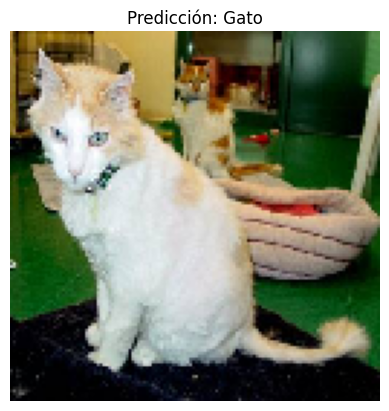

In [28]:
num_images_to_test = 5

# Seleccionar aleatoriamente 'num_images_to_test' imágenes del repositorio
sample_images = random.sample(image_files, num_images_to_test)

# Recorrer cada imagen seleccionada
for image_path in sample_images:

    # Preprocesar la imagen para que sea compatible con el modelo
    image_preprocessed = load_and_preprocess_image(image_path, target_size=(128, 128))

    # Realizar la predicción usando el modelo entrenado
    pred = model.predict(image_preprocessed)
    
    # Interpretar el resultado (suponiendo que < 0.5 es "Gato" y >= 0.5 es "Perro")
    if pred[0][0] < 0.5:
        prediction = "Gato"
    else:
        prediction = "Perro"
    
    print("Predicción:", prediction, "para imagen:", os.path.basename(image_path))

    # Cargar la imagen original para visualizarla
    img_display = load_img(image_path, target_size=(128, 128))
    
    # Mostrar la imagen con la predicción
    plt.imshow(img_display)
    plt.title("Predicción: " + prediction)
    plt.axis("off")
    plt.show()

In [29]:
# Guardamos el modelo

model.save('../models/classifier_cats_dogs.h5')